<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/OOP_Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.6 MB/s 
     |████████████████████████████████| 458 kB 34.7 MB/s 
     |████████████████████████████████| 131 kB 41.0 MB/s 
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2633 sha256=6a0670ba3d183037b1b73427fed6e3174fddf3f0977c5ffc790cbd791cf246f2
  Stored in directory: /root/.cache/pip/wheels/bb/58/2a/4109ff5870c163b26a499fb8b828ede50e96264571a4f082d3
Successfully built julian
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.8 MB/s 
     |████████████████████████████████| 215 kB 37.4 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-py3-none-any.whl size=32667 sha256=67fc10dafa63d25ced1cee022aa1232e71fcbd7f7741a70693acf7212de18aa9
  Stored in directory: /root/.cache/pip/wheels/a0/c5/f3/548a073ac6a83d5b23d9b39cdd243

# Import extensions

In [3]:
import swmmio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Explore model data

In [4]:
model = swmmio.Model('example.inp')
df_links = model.links.dataframe
df_subcatchments = model.subcatchments.dataframe

In [5]:
df_links[:2]

,InletNode,OutletNode,...,Barrels,coords
Name,,,,,
C3,J1,J3,...,1,"[(777189.014, 592583.674), (777197.821, 592564.501)]"
C4,J3,O4,...,1,"[(777197.821, 592564.501), (777203.103, 592557.13)]"


In [6]:
df_subcatchments[:2]

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777175.934, 592588.598), (777185.333, 592588.986), (777185.453, 592579.676), (777176.173, 592579.527), (777175.934, 592588.717), (777175.934, 592588.598)]"


# Prepare methoed for sumulation

In [33]:
class PipeData:
    def __init__(self):
        self.flow_turn_sign = []
        self.flow_turns = []
        self.peak_depth = []        # maksymalna wysokość napełnienia kanału [m]
        self.peak_flow = []         # maksymaly przepływ [m3/s]
        self.peak_flow_date = []
        self.peak_velocity = []     # maksymalna prędkość przepływu [m/s]
        self.time_capacity_limited = []
        self.time_courant_crit = []
        self.time_full_downstream = []
        self.time_full_flow = []
        self.time_full_upstream = []
        self.time_normal_flow = []

class CatchmentData:
    def __init__(self):
        self.runoff = []
        self.peak_runoff_rate = []
        self.infiltration = []
        self.evaporation = []
        self.slope = []
        self.percent_impervious = []
        self.area = []


class Analyse:
    def __init__(self, file_path='example.inp'):
        self.pipe_data = PipeData()
        self.catchment_data = CatchmentData()
        self._file_path = file_path

    def show_subcatchment(self):
        with Simulation(self._file_path) as sim:
            return [subcatchment.subcatchmentid for subcatchment in Subcatchments(sim)]

    def show_conduits(self):
        with Simulation(self._file_path) as sim:
            return [conduit.linkid for conduit in Links(sim)]

    def save_model(self):
        # pyswmm not allow to manage diameter of pipe 
        # this is why it is nessesary to use swmmio 
        # to overide model data (max. depth - pipe diameter)
        pass

    def overide_diameter(self):
        pass
    
    def analyse(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        iterator = []
        counter = min_slope
        while counter < max_slope:
            counter += step
            iterator.append(counter)
        for area in range(1, 11, 1):
            for slope in iterator:
                for imprevious in iterator:
                    with Simulation(self._file_path) as sim:
                        catchment = Subcatchments(sim)[subcatchment_id]
                        conduit = Links(sim)[conduit_id]
                        catchment.slope = slope
                        catchment.percent_impervious = imprevious
                        catchment.area = area
                        self.catchment_data.slope.append(slope)
                        self.catchment_data.percent_impervious.append(imprevious) 
                        self.catchment_data.area.append(area)
                        for _ in sim:
                            pass
                        catchment_stats = catchment.statistics
                        conduit_stats = conduit.conduit_statistics
                        try:
                            for key in vars(self.catchment_data):
                                getattr(self.catchment_data, key).append(catchment_stats[key])
                        except KeyError:
                            pass
                        try:
                            for key in vars(self.pipe_data):
                                getattr(self.pipe_data, key).append(conduit_stats[key])
                        except KeyError:
                            pass
            print(f"loop: {area}")
        return None

    def simulation(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        counter = min_slope
        while counter < max_slope:
            with Simulation(self._file_path) as sim:
                conduit = Links(sim)[conduit_id]
                catchment = Subcatchments(sim)[subcatchment_id]
                catchment.slope = counter
                for _ in sim:
                    pass
                conduit_stats = conduit.conduit_statistics
                catchment_stats = catchment.statistics
                try:
                    for key in vars(self.catchment_data):
                        getattr(self.catchment_data, key).append(catchment_stats[key])
                except KeyError:
                    pass
                try:
                    for key in vars(self.pipe_data):
                        getattr(self.pipe_data, key).append(conduit_stats[key])
                except KeyError:
                    pass
                self.catchment_data.slope.append(counter)
                counter += step
        return None

# Do simulation

In [34]:
slope_analyse = Analyse()
slope_analyse.simulation("C3", "S1", step=10)

In [19]:
feature_analyse = Analyse()
feature_analyse.analyse("C3", "S1", step=10)

loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
loop: 7
loop: 8
loop: 9
loop: 10


# Prepare dataframe



In [36]:
# data = {"slope": analyse.slope, **vars(analyse.pipe_data), **vars(analyse.catchment_data)}
data = {**vars(slope_analyse.pipe_data), **vars(slope_analyse.catchment_data)}
df_raw = pd.DataFrame(data=data)

ValueError: ignored

# Data for work

In [ ]:
df = df_raw.copy()
df.info()

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.describe().T

# Remove unused columns

In [ ]:
df.columns

In [ ]:
df.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream'], axis=1, inplace=True)
df.head()

# Subcatchments data output

## Dependence of runoff on subcatchment slope.

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('Dependence of runoff on subcatchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

## Dependence of peak runoff rate on subcatchment slope

In [ ]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

## Dependence of infiltration on subcatchment slope

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Pipes data output

## Dependence of maximal flow on subcatchment slope.

In [ ]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

## Dependence of maximal velocity on subcatchment slope

In [ ]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

## Dependence of maximal pipe filling on subcatchment slope.

In [ ]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

# Show correlations betwen features as heatmap

## Prepare dataframe with selected features

In [ ]:
# feature_data = {**vars(feature_analyse.pipe_data), **vars(feature_analyse.catchment_data)}
feature_data = {**vars(feature_analyse.catchment_data)}
df_raw_feature = pd.DataFrame(data=feature_data)

In [ ]:
# print(df_raw_feature.columns)

In [ ]:
df_corr = df_raw_feature.copy()
# df_corr[['slope', 'runoff', 'peak_runoff_rate', 'infiltration']] = df_raw_feature[['slope', 'runoff', 'peak_runoff_rate', 'infiltration']]
df_corr[['slope', 'runoff', 'peak_runoff_rate', 'infiltration']] = df_raw_feature[['slope', 'runoff', 'peak_runoff_rate', 'infiltration']]
print(df_corr[:-10])

          runoff  peak_runoff_rate  ...  percent_impervious  area
0     992.275502          0.276624  ...                10.1     1
1     992.275502          0.276624  ...                20.1     1
2     992.275502          0.276624  ...                30.1     1
3     992.275502          0.276624  ...                40.1     1
4     992.275502          0.276624  ...                50.1     1
..           ...               ...  ...                 ...   ...
985  9949.104929          2.766508  ...                60.1    10
986  9949.104929          2.766508  ...                70.1    10
987  9949.104929          2.766508  ...                80.1    10
988  9949.104929          2.766508  ...                90.1    10
989  9949.104929          2.766508  ...               100.1    10

[990 rows x 7 columns]


In [ ]:
corr = df_corr.corr()

## Plot heatmap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


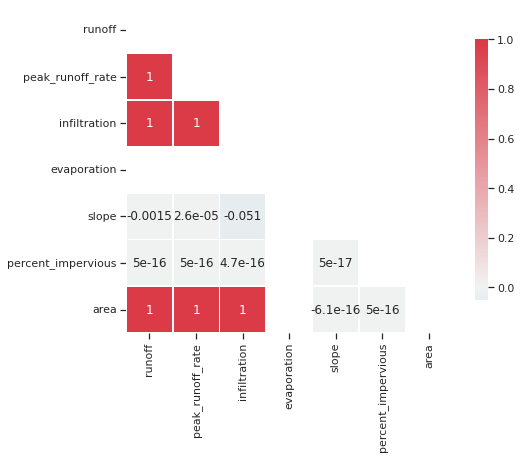

In [ ]:
import seaborn as sns

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

In [ ]:
!jupyter nbconvert --to pdf /content/KNN.ipynb

[NbConvertApp] WARNING | pattern '/content/KNN.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  